## Question 4

Use the COVID Case Surveillance dataset to fit a regression model that predicts the total percent (or proportion) of deaths out of all COVID cases in a given month based on :
- Gender distribution of all cases over the month (Proportion or % of females and
males).
- Age distribution of all cases over the month (Proportion or % of each age group).
- Proportion (or %) of all cases over the month that end up in the ICU.
- Proportion (or %) of all cases over the month that end up hospitalized.

In [2]:
import pandas as pd

In this next cell I import the data and only the columns I am interested in, then I filter all the missing values and the unknown values and calculate the means of the values i need

In [11]:
relevant_columns = [
    'case_month', 'age_group', 'sex', 'hosp_yn', 'icu_yn', 'death_yn'
]


df = pd.read_csv('data.csv', usecols=relevant_columns)


covid_data_filtered = df.dropna(subset=['age_group', 'sex', 'hosp_yn', 'icu_yn', 'death_yn'])

covid_data_filtered = covid_data_filtered[
    (covid_data_filtered['hosp_yn'] != 'Missing') & (covid_data_filtered['hosp_yn'] != 'Unknown') &
    (covid_data_filtered['icu_yn'] != 'Missing') & (covid_data_filtered['icu_yn'] != 'Unknown') &
    (covid_data_filtered['death_yn'] != 'Missing') & (covid_data_filtered['death_yn'] != 'Unknown')
]


covid_data_grouped = covid_data_filtered.groupby('case_month').apply(
    lambda x: pd.Series({
        'female_proportion': (x['sex'] == 'Female').mean(),
        'age_0_17_proportion': (x['age_group'] == '0 - 17 years').mean(),
        'age_18_49_proportion': (x['age_group'] == '18 to 49 years').mean(),
        'age_50_64_proportion': (x['age_group'] == '50 to 64 years').mean(),
        'age_65_proportion': (x['age_group'] == '65+ years').mean(),
        'icu_proportion': (x['icu_yn'] == 'Yes').mean(),
        'hospitalized_proportion': (x['hosp_yn'] == 'Yes').mean(),
        'death_proportion': (x['death_yn'] == 'Yes').mean()
    })
).reset_index()

/tmp/ipykernel_30118/1127614148.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  covid_data_grouped = covid_data_filtered.groupby('case_month').apply(


Save it to be available to use quickly after that

In [46]:
covid_data_grouped.to_csv("Grouped_Data.csv")

In [1]:
import pandas as pd

grouped_df = pd.read_csv('Grouped_Data.csv')

In [2]:
import pandas as pd
import statsmodels.api as sm

file_path = 'Grouped_Data.csv'
data = pd.read_csv(file_path)

X = data[['female_proportion', 'age_0_17_proportion', 'age_18_49_proportion', 
          'age_50_64_proportion', 'age_65_proportion', 'icu_proportion', 'hospitalized_proportion']]
y = data['death_proportion']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       death_proportion   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     15.74
Date:                Wed, 22 May 2024   Prob (F-statistic):           2.27e-09
Time:                        13:39:26   Log-Likelihood:                 134.34
No. Observations:                  49   AIC:                            -254.7
Df Residuals:                      42   BIC:                            -241.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# * Intercept (const):
    * Coefficient: 0.2141
    * p-value: 0.002
# * female_proportion:
    * Coefficient: -0.3489
    * p-value: 0.015
# * age_0_17_proportion:
    * Coefficient: -0.0413
    * p-value: 0.184
# * age_18_49_proportion:
    * Coefficient: -0.1005
    * p-value: 0.035
# * age_50_64_proportion:
    * Coefficient: 0.4010
    * p-value: 0.000
# * age_65_proportion:
    * Coefficient: -0.0451
    * p-value: 0.420
# * icu_proportion:
    * Coefficient: 0.5399
    * p-value: 0.008
# * hospitalized_proportion:
    * Coefficient: -0.1719
    * p-value: 0.071

## Good Predictors:

1. female_proportion (p-value = 0.015)
2. age_18_49_proportion (p-value = 0.035)
3. age_50_64_proportion (p-value = 0.000)
4. icu_proportion (p-value = 0.008)
## Bad Predictors:

1. age_0_17_proportion (p-value = 0.184)
2. age_65_proportion (p-value = 0.420)
3. hospitalized_proportion (p-value = 0.071)

The model has R-squared value of 0.692, that means it is closer to 1 and it somehow explains the variability in the response variable Y

Let's calculate the Variance Inflation Factor (VIF) for each predictor to assess multicollinearity and lets plot each variable against the other variable.

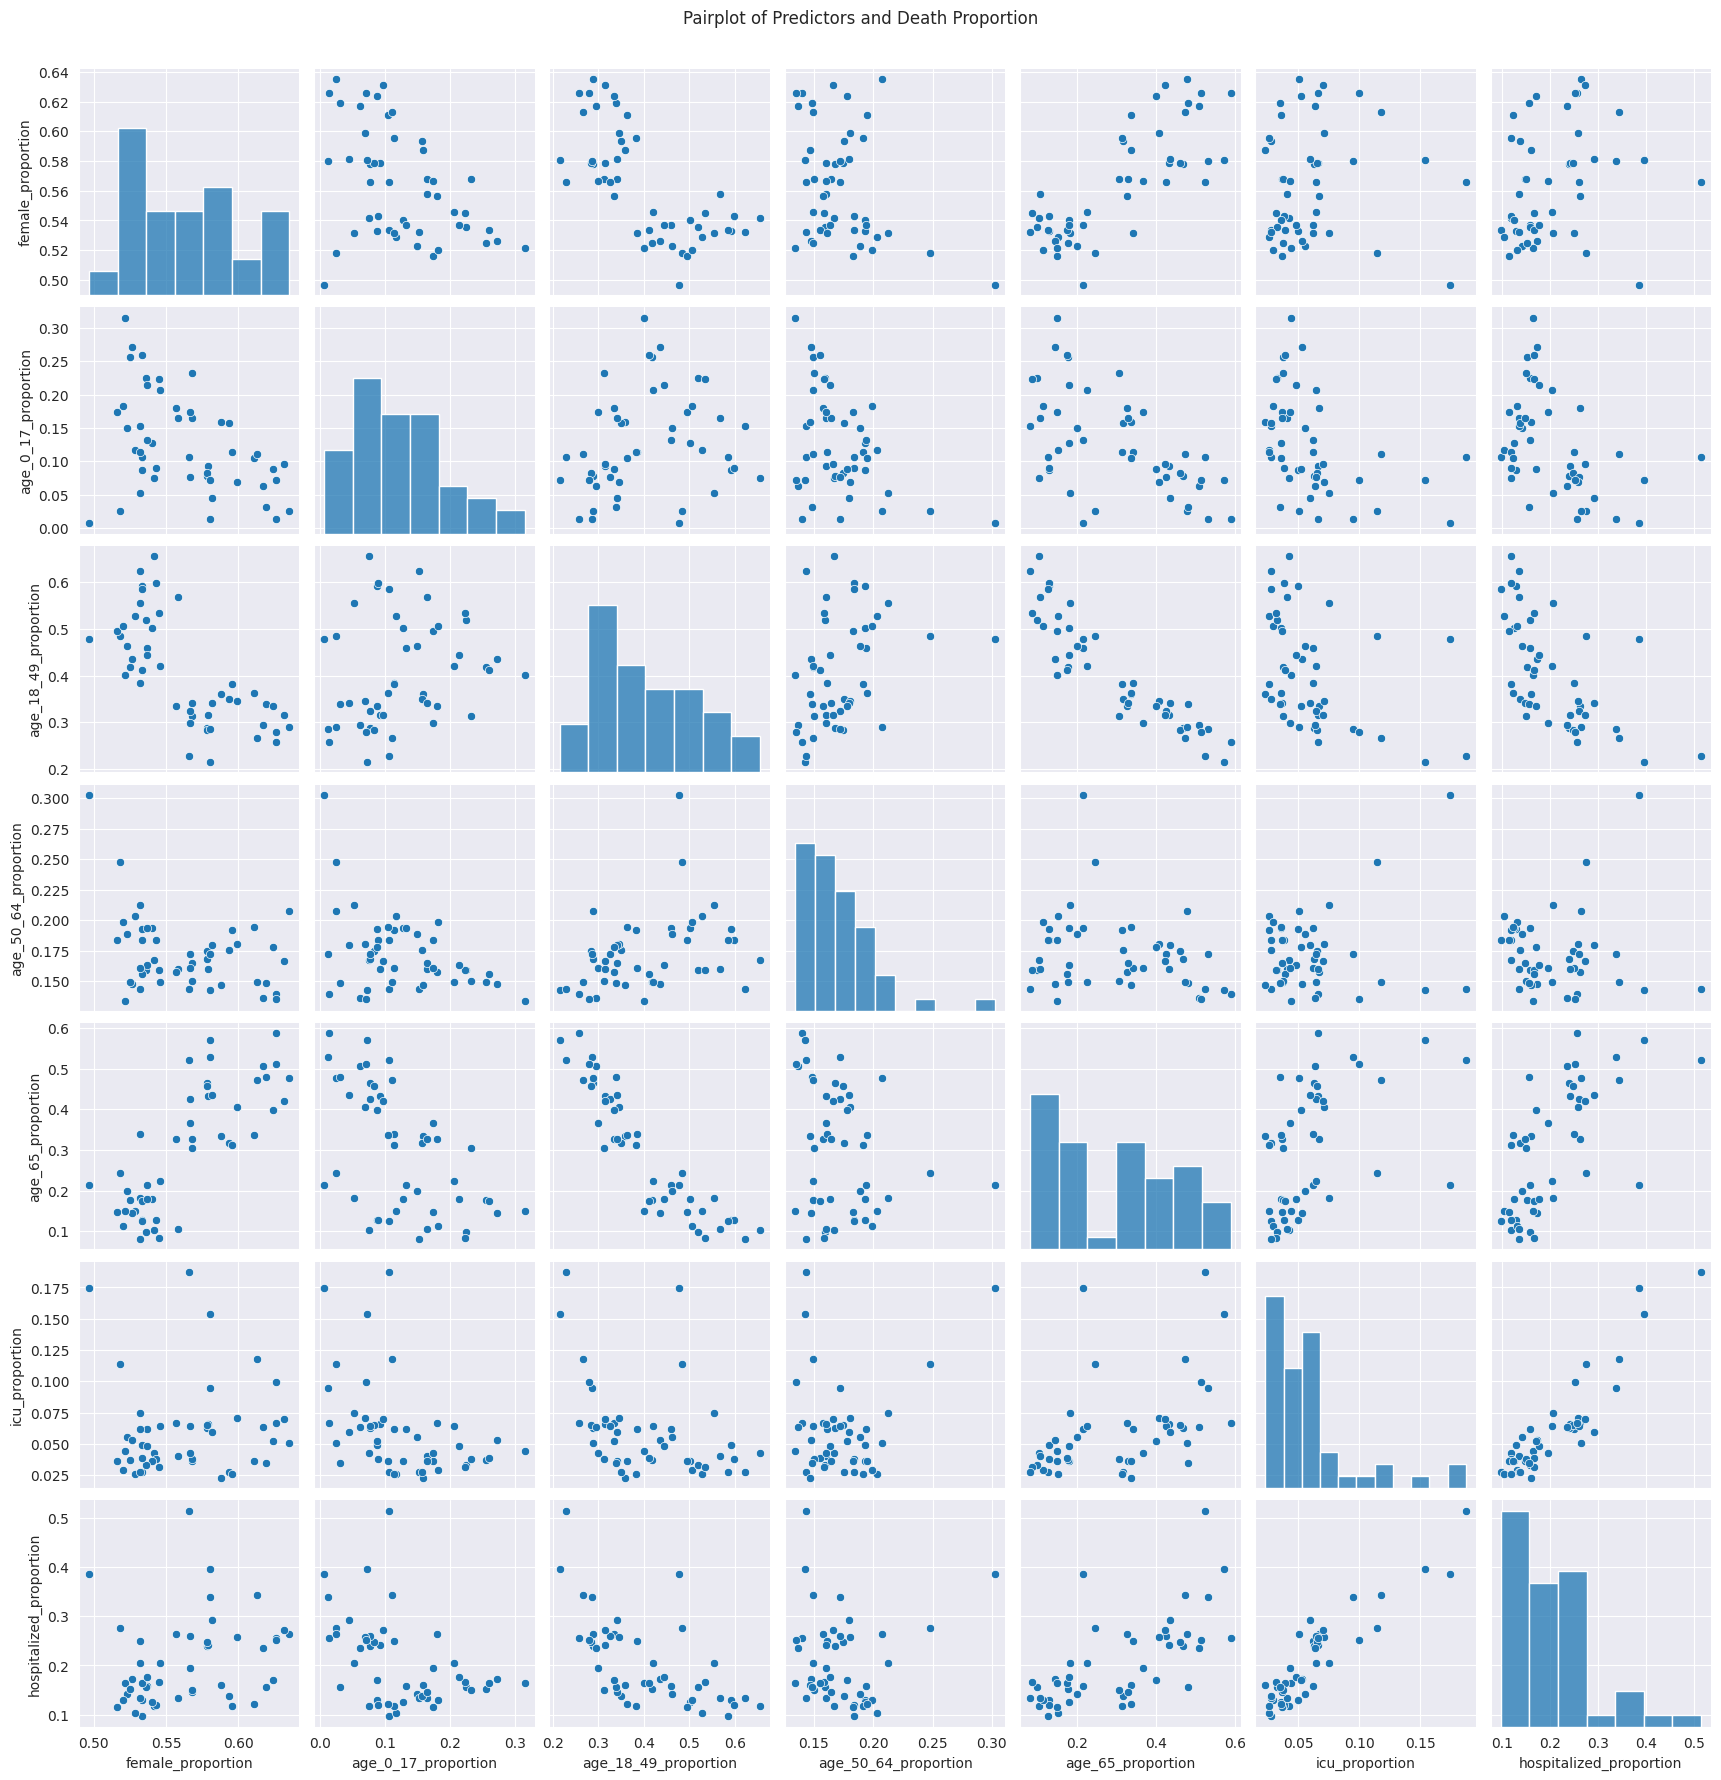

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot of the final predictors to visualize relationships
pairplot_data = data[['female_proportion', 'age_0_17_proportion', 'age_18_49_proportion', 
          'age_50_64_proportion', 'age_65_proportion', 'icu_proportion', 'hospitalized_proportion']]

# Create pairplot
sns.pairplot(pairplot_data)
plt.suptitle('Pairplot of Predictors and Death Proportion', y=1.02)
plt.show()


From the graph is is not really apparent what is correlated(the only apparent ones are ICU propotions and hospitalized propotions, and age portion 65 with age 18-49), lets try heatmap

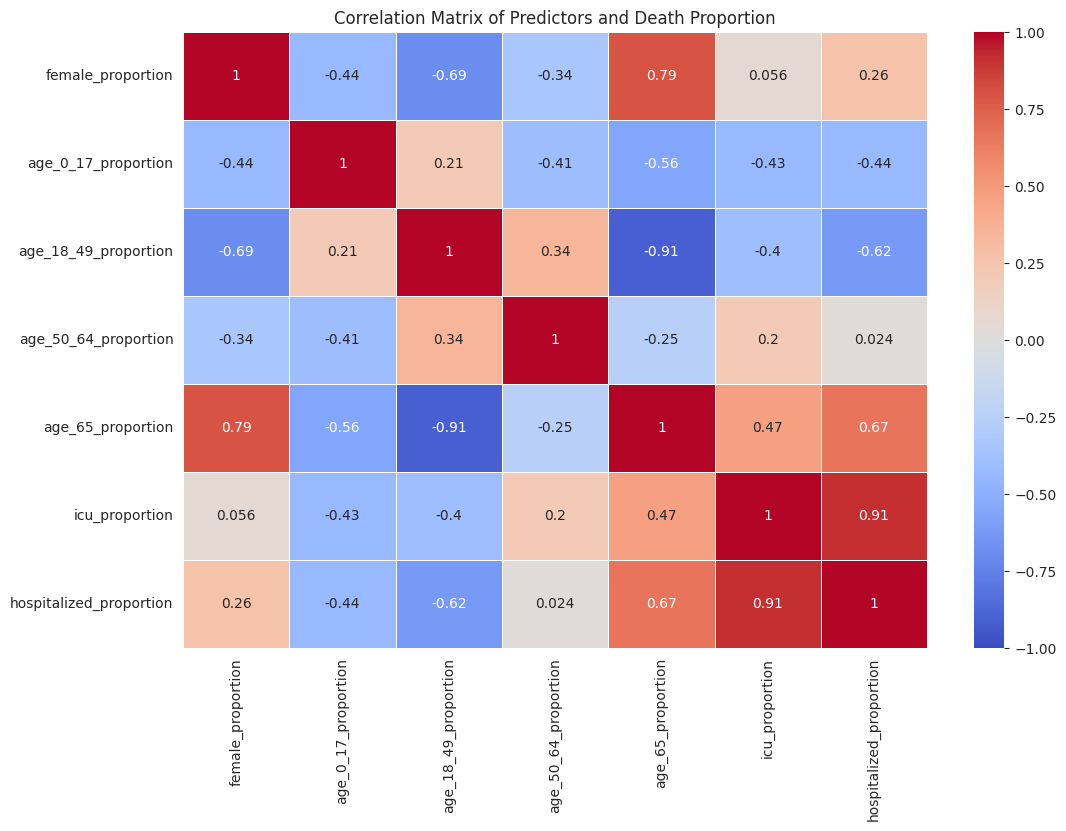

In [9]:
# Calculate the correlation matrix
correlation_matrix = pairplot_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Predictors and Death Proportion')
plt.show()


ICU propotion is highly correlated with hospitalized propotion, age 65 propotion is highly negatively correlated with age 18-45 propotion

Lets check VIT factor

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data


/home/ahmed/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/ahmed/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,const,0.000000
1,female_proportion,4.416857
2,age_0_17_proportion,inf
3,age_18_49_proportion,inf
4,age_50_64_proportion,inf
5,age_65_proportion,inf
6,icu_proportion,8.472324
7,hospitalized_proportion,11.104651


age_0_17_proportion, age_18_49_proportion, age_50_64_proportion, age_65_proportion all have infinite VIFs, suggesting perfect collinearity. Which is obvious as all these variables are dependent on each other, their sum must add up to 1

Also ICU_propotion and hospitalized_propotion are having high VIT factor, they have high multicollinearity, we can either combine them into one feature or remove one of them

Lets try removing the intercept

In [11]:
model_no_intercept = sm.OLS(y, X.drop(columns='const')).fit()
print(model_no_intercept.summary())


                            OLS Regression Results                            
Dep. Variable:       death_proportion   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     15.74
Date:                Wed, 22 May 2024   Prob (F-statistic):           2.27e-09
Time:                        18:07:25   Log-Likelihood:                 134.34
No. Observations:                  49   AIC:                            -254.7
Df Residuals:                      42   BIC:                            -241.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
female_proportion         

Removing the intercept did not change anything in the R squared Metric

In [12]:
X_with_higher_order = X.copy()
for col in X_with_higher_order.columns:
    if col != 'const':
        X_with_higher_order[f'{col}^2'] = X_with_higher_order[col] ** 2

model_higher_order = sm.OLS(y, X_with_higher_order).fit()
print(model_higher_order.summary())


                            OLS Regression Results                            
Dep. Variable:       death_proportion   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     20.04
Date:                Wed, 22 May 2024   Prob (F-statistic):           1.90e-12
Time:                        18:08:03   Log-Likelihood:                 157.74
No. Observations:                  49   AIC:                            -287.5
Df Residuals:                      35   BIC:                            -261.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

The R-Squared Value is increased here to be 0.882 and the F-Statistic is 20.04 and it is a high F statistic

High F-statistic: Indicates that at least one of the predictor variables is significantly related to the dependent variable.